# Load Data

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
os.chdir("/content/drive/Shareddrives/cis522_project/cleaned_data")

In [315]:
articles = pd.read_csv('filtered_articles.csv', index_col=0)
customers = pd.read_csv('filtered_customer.csv', index_col=0)
transactions = pd.read_csv("filtered_transactions.csv", index_col=0)

# Create graph and features

In [316]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [317]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import dgl.data

In [318]:
transactions.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,year
147,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,671515001,0.024424,2,2018
403,2018-09-20,022064800152ad93969188799580e0d2173bc7696f6dee...,556438001,0.033881,2,2018
530,2018-09-20,02a02c0969c67adde90ede610a54b365c31187872585ea...,657395001,0.033881,1,2018
2676,2018-09-20,0f7c23ef284b58a559595a93ed7609a84e1277cf52a2a2...,524825013,0.040237,1,2018
2781,2018-09-20,104cf4fb2bdf00c1cbd252feb71d85b4efe51a6d88df7b...,529008026,0.025407,2,2018


## nodes

In [319]:
# nodes are articles
nodes = list(articles.article_id)

## edges

In [320]:
from itertools import combinations

In [321]:
transactions.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,year
147,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,671515001,0.024424,2,2018
403,2018-09-20,022064800152ad93969188799580e0d2173bc7696f6dee...,556438001,0.033881,2,2018


In [322]:
customers.head(2)

,customer_id,club_member_status,fashion_news_frequency,age
378,00123f33890b09df6220e166ff7017307d46d6bedb7d41...,ACTIVE,None,30.0
491,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f...,ACTIVE,None,54.0


In [323]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4980 entries, 378 to 1371958
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             4980 non-null   object 
 1   club_member_status      4980 non-null   object 
 2   fashion_news_frequency  4980 non-null   object 
 3   age                     4980 non-null   float64
dtypes: float64(1), object(3)
memory usage: 194.5+ KB


In [324]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146499 entries, 147 to 31787367
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   t_dat             146499 non-null  object 
 1   customer_id       146499 non-null  object 
 2   article_id        146499 non-null  int64  
 3   price             146499 non-null  float64
 4   sales_channel_id  146499 non-null  int64  
 5   year              146499 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.8+ MB


In [325]:
transactions_customers = transactions.merge(customers, on=['customer_id'])

In [326]:
transactions_customers.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,year,club_member_status,fashion_news_frequency,age
0,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,671515001,0.024424,2,2018,ACTIVE,Regularly,34.0
1,2018-11-21,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,578478001,0.027102,2,2018,ACTIVE,Regularly,34.0


In [327]:
# edges are pairs of nodes that have been bought by the same customer
edges = pd.DataFrame()
for customer in customers.customer_id:
  age = customers[customers['customer_id']== customer].iloc[0]['age']
  bought = transactions[transactions['customer_id'] == customer][['article_id']].drop_duplicates()
  comb = combinations(bought.article_id.to_list(), 2)
  comb = pd.DataFrame(comb)
  comb['age'] = age
  edges = pd.concat([edges, comb], ignore_index=True)

In [328]:
edges = edges.rename(columns={0: "article_id", 1: "also_bought"})

In [329]:
edges

,article_id,also_bought,age
0,699075001.0,693243002.0,30.0
1,699075001.0,721060001.0,30.0
2,699075001.0,721059001.0,30.0
3,699075001.0,464297007.0,30.0
4,699075001.0,803772001.0,30.0
...,...,...,...
1610498,745843002.0,611415005.0,27.0
1610499,745843002.0,823165001.0,27.0
1610500,745843001.0,611415005.0,27.0
1610501,745843001.0,823165001.0,27.0


In [330]:
edges = edges.groupby(by=["article_id","also_bought"]).mean().reset_index()

In [331]:
edges

,article_id,also_bought,age
0,108775015.0,108775044.0,34.88
1,108775015.0,111586001.0,40.40
2,108775015.0,111593001.0,44.00
3,108775015.0,111609001.0,39.00
4,108775015.0,120129001.0,33.00
...,...,...,...
1094163,933706001.0,719655001.0,22.00
1094164,933706001.0,751471001.0,46.00
1094165,933706001.0,764280001.0,40.00
1094166,933706001.0,865929003.0,40.00


In [332]:
edges = edges.drop_duplicates()

In [333]:
edges.to_csv('edges.csv', index=False)

## map article_id to 0 - # of nodes

In [334]:
asin_map_dict = pd.Series(edges.article_id.append(edges.also_bought).unique()).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

edges.article_id = edges.article_id.apply(lambda x: asin_map[x])
edges.also_bought = edges.also_bought.apply(lambda x: asin_map[x])


In [335]:
edges

,article_id,also_bought,age
0,0,1,34.88
1,0,3,40.40
2,0,4,44.00
3,0,5,39.00
4,0,6,33.00
...,...,...,...
1094163,1987,972,22.00
1094164,1987,1208,46.00
1094165,1987,1342,40.00
1094166,1987,1942,40.00


## Text Manipulations

In [336]:
articles.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [337]:
#TF-IDF Vectorizer for Text Feature of each article
from sklearn.feature_extraction.text import TfidfVectorizer

desc = articles['prod_name'] + articles['product_type_name'] + articles['product_group_name']+ articles['graphical_appearance_name']+ articles['colour_group_name']+ articles['department_name']+ articles['index_group_name'] +articles['garment_group_name'] + articles['detail_desc']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(desc))
X.toarray().shape

(1988, 2995)

## Build graph

In [338]:
node_features = torch.Tensor(X.toarray())
# node_labels = torch.from_numpy(articles['prod_name'].astype('category').cat.codes.to_numpy())
edge_features = torch.from_numpy(edges['age'].to_numpy())
edges_src = torch.from_numpy(edges['article_id'].to_numpy())
edges_dst = torch.from_numpy(edges['also_bought'].to_numpy())

In [339]:
g = dgl.graph((edges_src, edges_dst))
g.ndata['feat'] = node_features
# g.ndata['label'] = node_labels
g.edata['feat'] = edge_features

In [340]:
print(g)

Graph(num_nodes=1988, num_edges=1094168,
      ndata_schemes={'feat': Scheme(shape=(2995,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.float64)})


# Prepare training and testing sets

randomly picks 10% of the edges for examples in the test set, and leave the rest for the training set. 

In [341]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())),shape=(g.num_nodes(), g.num_nodes()))
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

In [342]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [343]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# Define a GraphSAGE model

This model consisting of two GraphSAGE <https://arxiv.org/abs/1706.02216>__ layers, each computes new node representations by averaging neighbor information. DGL provides dgl.nn.SAGEConv that conveniently creates a GraphSAGE layer.

In [344]:
from dgl.nn import SAGEConv

# ----------- create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
        # self.conv3 = SAGEConv(h_feats, h_feats, 'mean')
        # self.conv4 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        # h = F.relu(h)
        # h = self.conv3(g, h)
        # h = F.relu(h)
        # h = self.conv4(g, h)
        return h

In [345]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [346]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

# True Model

In [347]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [348]:
num_features = 64
model = GraphSAGE(g.ndata['feat'].shape[1], num_features)
pred = MLPPredictor(num_features)
# pred = DotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(g, g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


In epoch 0, loss: 0.6941119432449341
In epoch 5, loss: 0.6619191765785217
In epoch 10, loss: 0.6202671527862549
In epoch 15, loss: 0.5969099402427673
In epoch 20, loss: 0.5691863298416138
In epoch 25, loss: 0.5549440979957581
In epoch 30, loss: 0.5497392416000366
In epoch 35, loss: 0.5448445677757263
In epoch 40, loss: 0.5417277812957764
In epoch 45, loss: 0.5391086339950562
In epoch 50, loss: 0.5365813970565796
In epoch 55, loss: 0.5339667797088623
In epoch 60, loss: 0.5315764546394348
In epoch 65, loss: 0.5295950174331665
In epoch 70, loss: 0.5279148817062378
In epoch 75, loss: 0.5267791748046875
In epoch 80, loss: 0.5256600379943848
In epoch 85, loss: 0.5246050953865051
In epoch 90, loss: 0.523809552192688
In epoch 95, loss: 0.5233142375946045


In [349]:
# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

AUC 0.7993125813721438


In [350]:
true_pos = np.sum(pos_score.detach().numpy() >= 0, axis=0)
true_neg = np.sum(neg_score.detach().numpy() <= 0, axis=0)
accuracy = (true_pos + true_neg) / (len(pos_score)+len(neg_score))
accuracy

0.7173493821744534

In [351]:
edges

,article_id,also_bought,age
0,0,1,34.88
1,0,3,40.40
2,0,4,44.00
3,0,5,39.00
4,0,6,33.00
...,...,...,...
1094163,1987,972,22.00
1094164,1987,1208,46.00
1094165,1987,1342,40.00
1094166,1987,1942,40.00


In [363]:
res_edges = pd.read_csv('edges.csv')
res_edges = res_edges.drop(columns='age')
res_edges['res'] = pred(g, h).detach().numpy()

In [364]:
res_edges

,article_id,also_bought,res
0,108775015.0,108775044.0,2.600765
1,108775015.0,111586001.0,3.439678
2,108775015.0,111593001.0,2.618123
3,108775015.0,111609001.0,0.729825
4,108775015.0,120129001.0,0.523449
...,...,...,...
1094163,933706001.0,719655001.0,-5.621251
1094164,933706001.0,751471001.0,-3.746605
1094165,933706001.0,764280001.0,-4.758245
1094166,933706001.0,865929003.0,-2.376065


# visualization

In [354]:
demo_customer = '09218960c278039863ca72e08255c245ade5466e3b90bf718a142087b5d27646'

In [355]:
demo_bought = transactions[transactions['customer_id'] == demo_customer]['article_id'].tolist()

In [356]:
demo_bought

[685848005,
 685848005,
 685848005,
 562245004,
 562245046,
 655784001,
 661306008,
 703826001,
 703826001,
 703826001,
 788846004,
 821643001,
 608776002,
 812683016,
 838787005,
 838787005,
 562245050,
 734460001,
 734460001]

## show what the customeractuallt bought

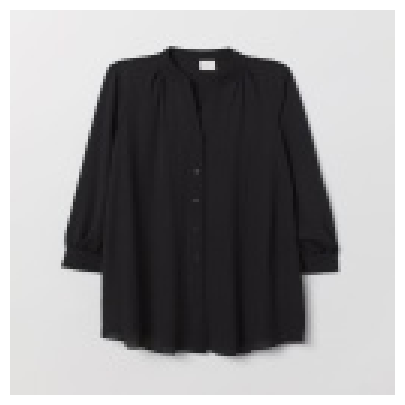

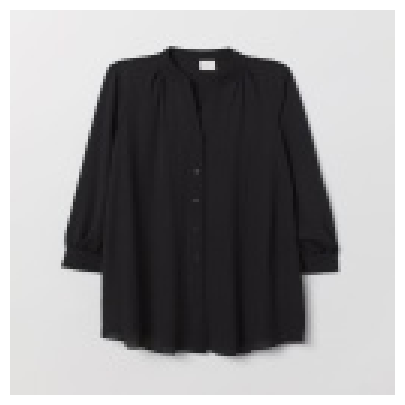

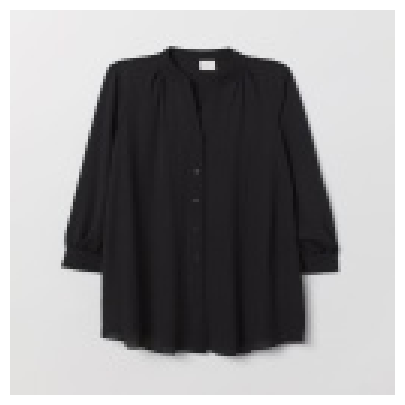

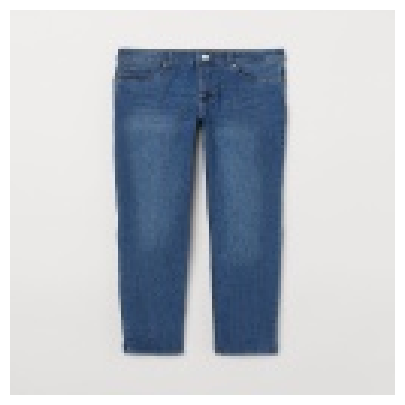

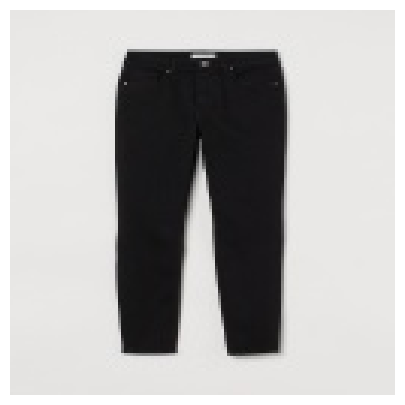

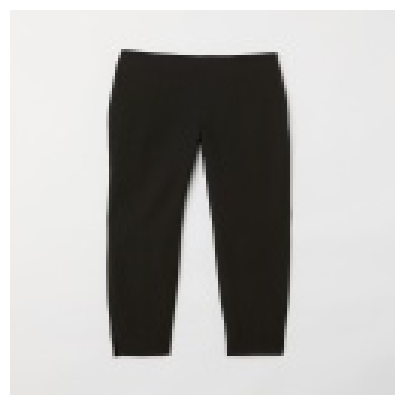

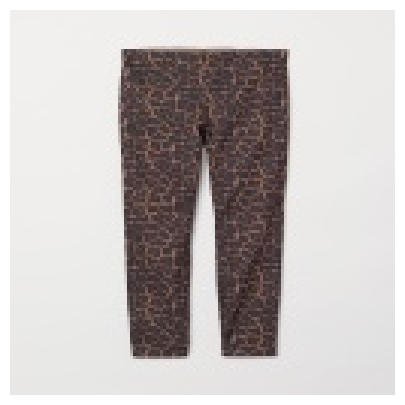

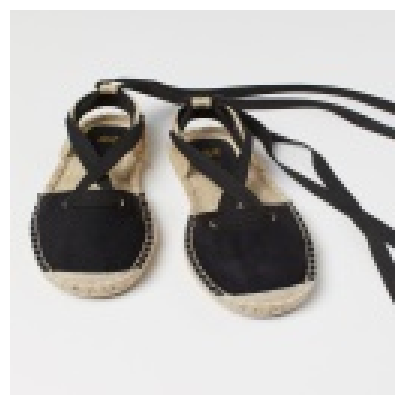

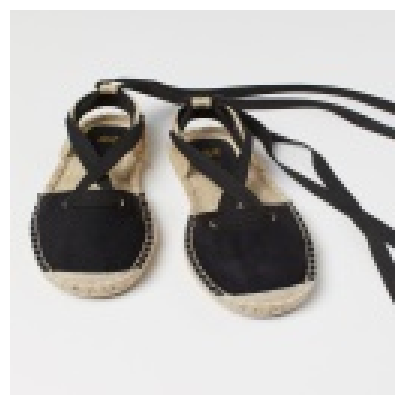

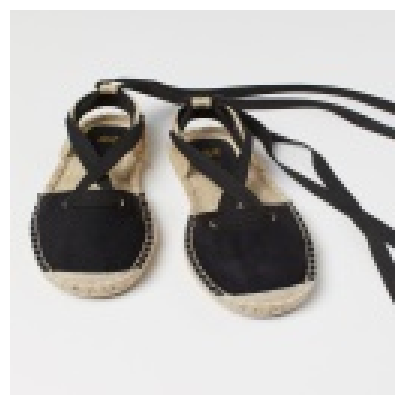

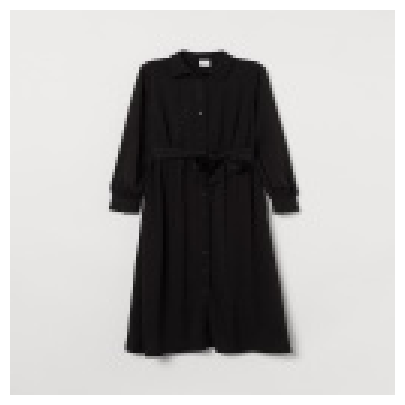

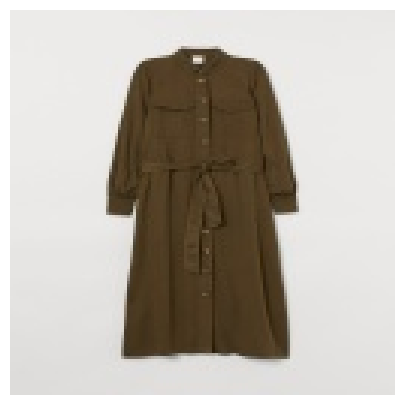

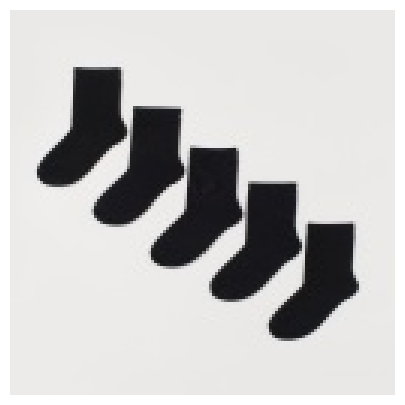

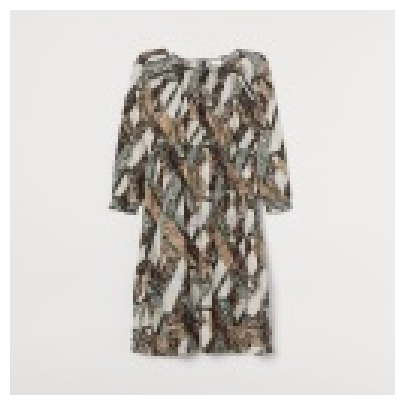

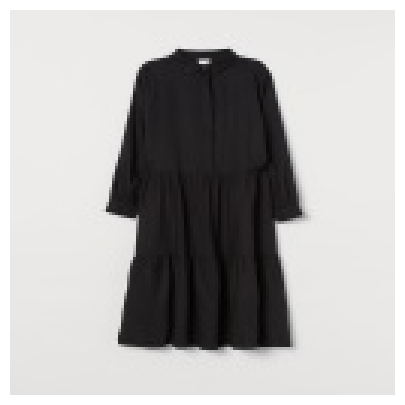

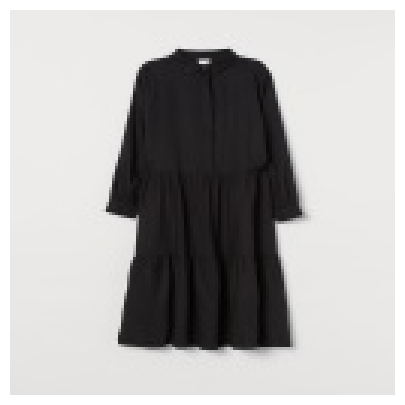

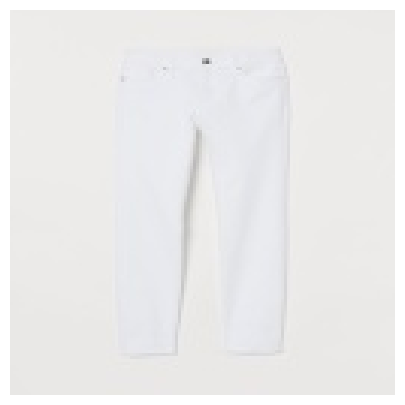

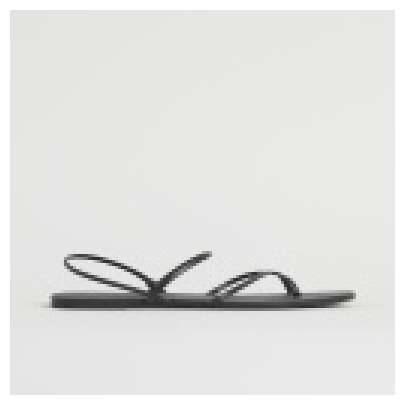

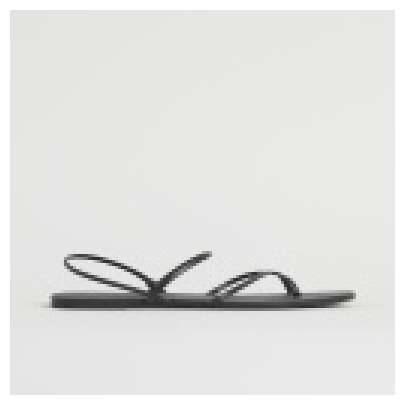

In [357]:
for id in demo_bought:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  plt.figure(figsize=(20,5))
  img1 = cv2.imread(name1)[:,:,::-1]
  plt.axis('off')
  plt.imshow(img1)

## recommend using one article (685848005)

In [365]:
recommend_articles = res_edges[res_edges['article_id'] == 734460001].sort_values(by='res',ascending=False)[:20]

In [366]:
recommend_articles = recommend_articles['also_bought']

In [367]:
for id in recommend_articles:
  item = int(id)
  print(item)

751471001
783346001
372860002
749699001
610776002
610776001
803757001
372860001
753737001
599580055
762846001
749699002
762846006
827968004
827968001
762846008
832361003
832361001
866383001
800691007


In [368]:
transactions[transactions['article_id'] == 610776002]

,t_dat,customer_id,article_id,price,sales_channel_id,year
18029,2018-09-20,5e65df96bb9fd029e2551b221ffef44df17cf731bf0499...,610776002,0.008458,1,2018
20404,2018-09-20,6a39044306e78b04783959baa3d9adc1cdde5c3468e591...,610776002,0.008458,1,2018
33918,2018-09-20,b2634c066779846ab9e603aefb406d88bab3988d0ed84c...,610776002,0.008458,2,2018
35957,2018-09-20,bdcfd2eca0388b2ded9efd218069e8cef173ed487a138c...,610776002,0.008458,2,2018
46991,2018-09-20,f8e1b3a598bfcc53b9437619e3b77d4e2c614e3b557025...,610776002,0.008458,2,2018
...,...,...,...,...,...,...
31187226,2020-09-06,1a8f9d9830d9a097214a35e6c15a03ba495b0ef133b774...,610776002,0.008458,2,2020
31368480,2020-09-10,da3beb9bc783e93f5635953bcc5ff8f7fc36cb30811e2f...,610776002,0.008458,2,2020
31523230,2020-09-15,0c9bc790328b2c59d8f48aa94cd97f5100d69a0c40656e...,610776002,0.008271,2,2020
31523231,2020-09-15,0c9bc790328b2c59d8f48aa94cd97f5100d69a0c40656e...,610776002,0.008271,2,2020


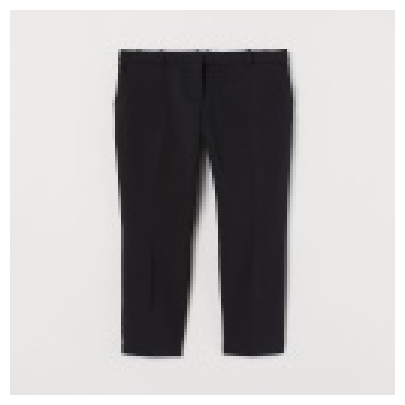

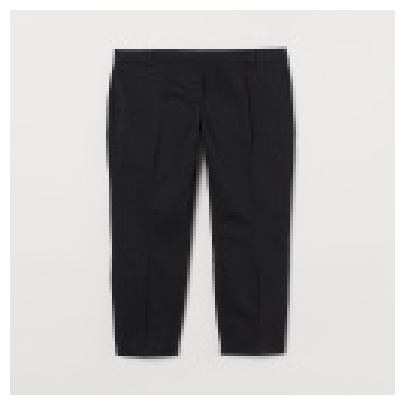

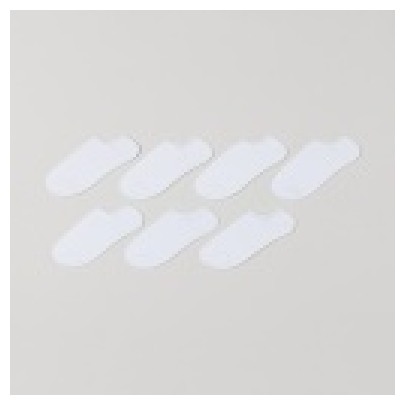

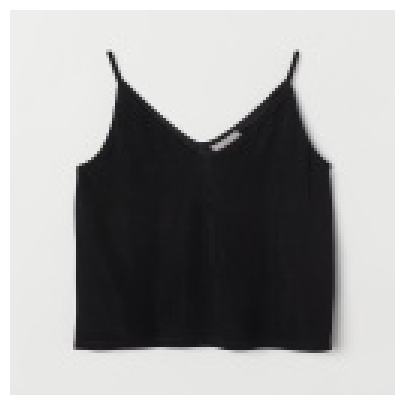

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

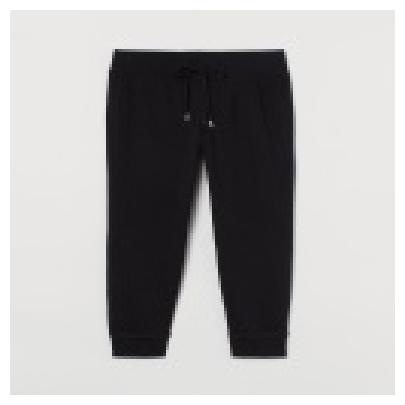

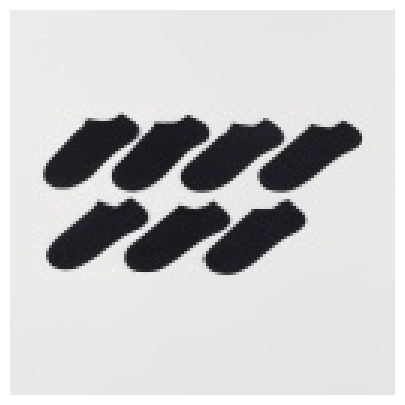

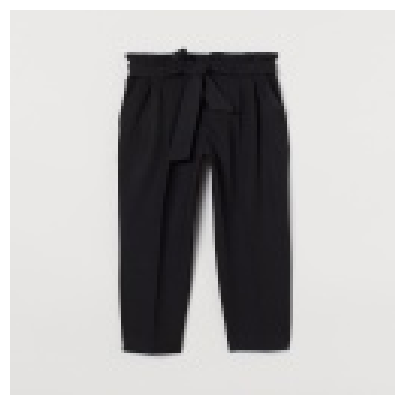

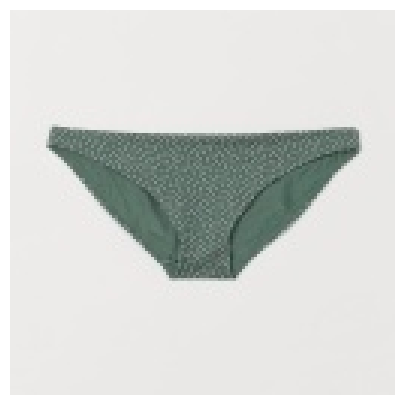

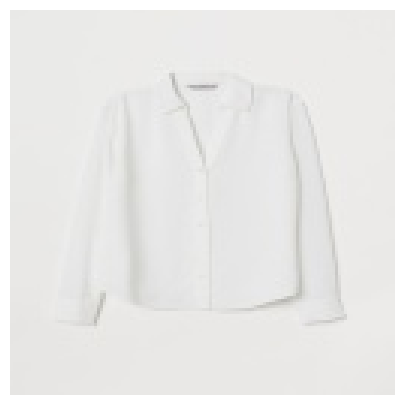

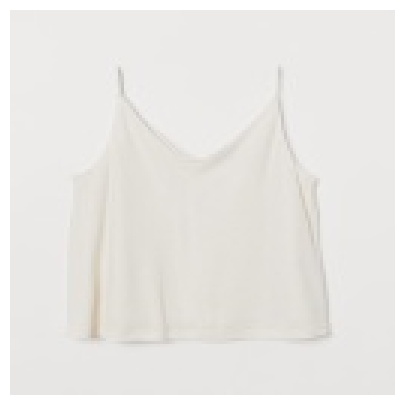

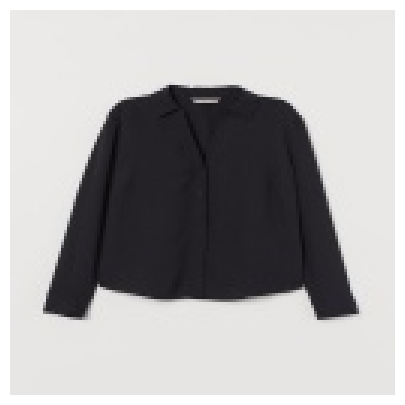

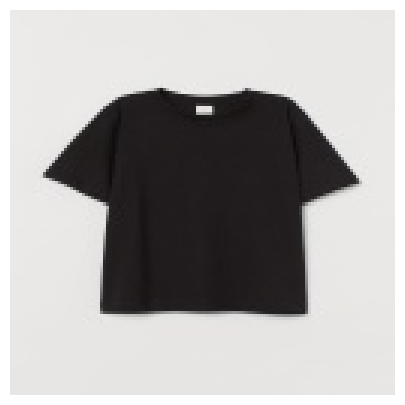

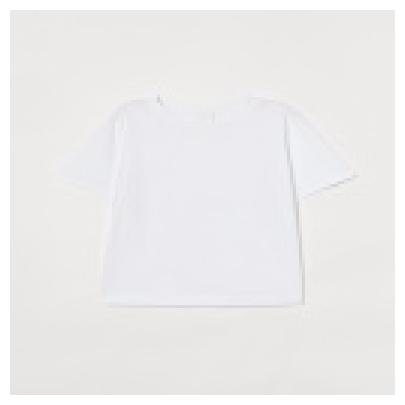

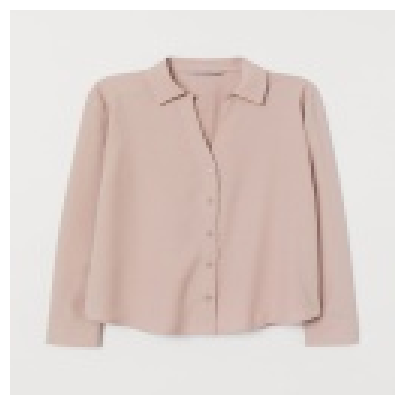

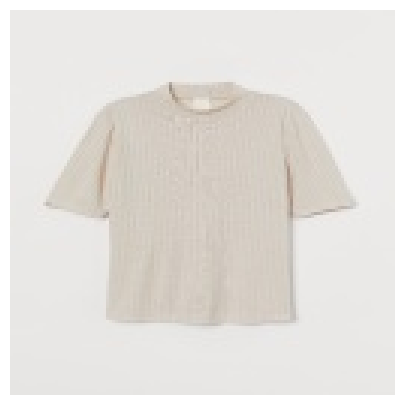

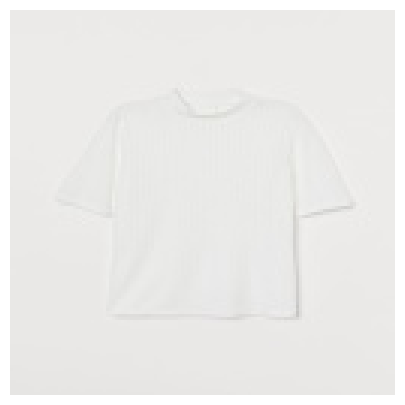

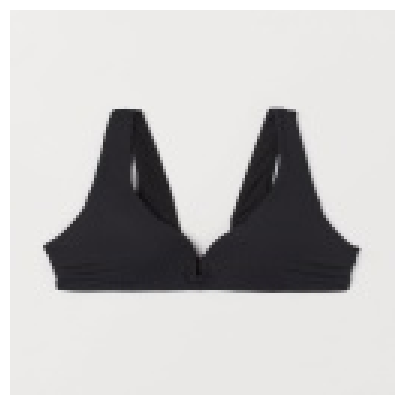

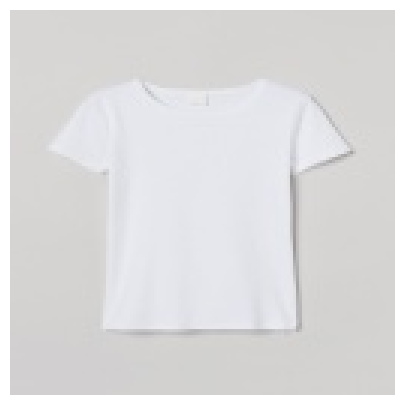

In [369]:
import cv2
for id in recommend_articles:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  plt.figure(figsize=(20,5))
  if (type(cv2.imread(name1)) == np.ndarray):
    img1 = cv2.imread(name1)[:,:,::-1]
    plt.axis('off')
    plt.imshow(img1)

## Full recommend list

In [370]:
recommend_list = pd.DataFrame()
for art_id in demo_bought:
  recommend_articles = res_edges[res_edges['article_id'] == art_id]
  recommend_list = pd.concat([recommend_list, recommend_articles], ignore_index=True)
recommend_list = recommend_list.sort_values(by='res',ascending=False)
recommend_list = recommend_list.drop_duplicates(subset=['also_bought'])
recommend_list = recommend_list[:20]

In [371]:
recommend_list

,article_id,also_bought,res
5931,661306008.0,673677002.0,5.546988
3166,562245046.0,610776002.0,5.300747
5553,661306008.0,372860001.0,5.276730
3165,562245046.0,610776001.0,5.219406
2892,562245046.0,372860002.0,5.190509
5926,661306008.0,673396002.0,5.176151
3735,562245046.0,751471001.0,5.153091
3727,562245046.0,749699001.0,4.989664
3954,562245046.0,783346001.0,4.986184
5730,661306008.0,573716012.0,4.919311


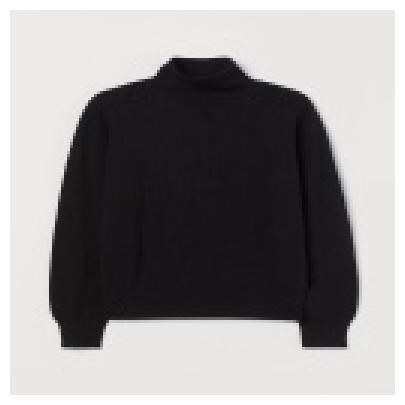

<Figure size 2000x500 with 0 Axes>

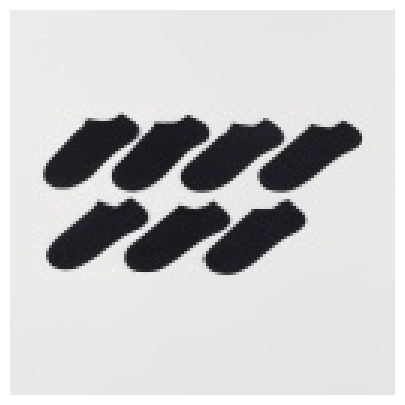

<Figure size 2000x500 with 0 Axes>

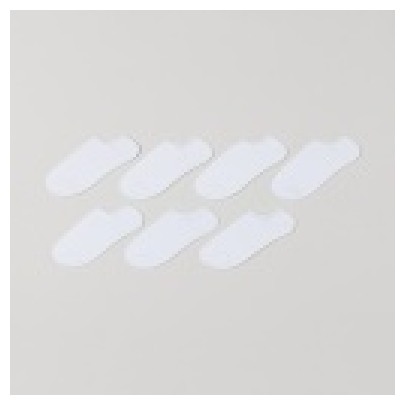

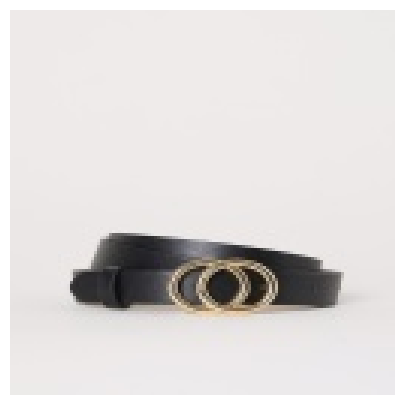

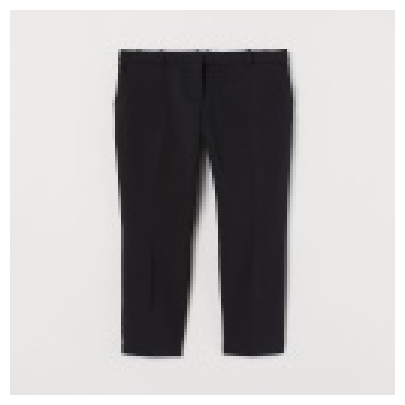

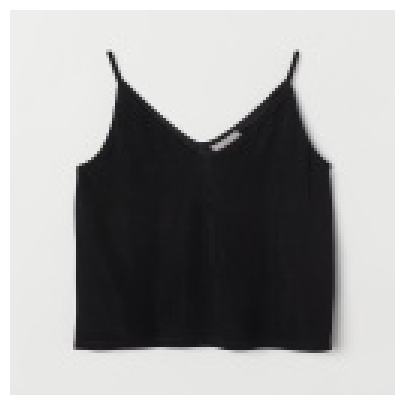

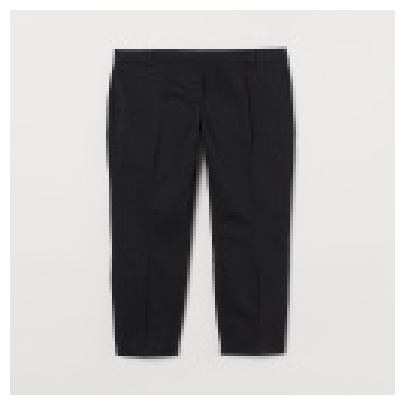

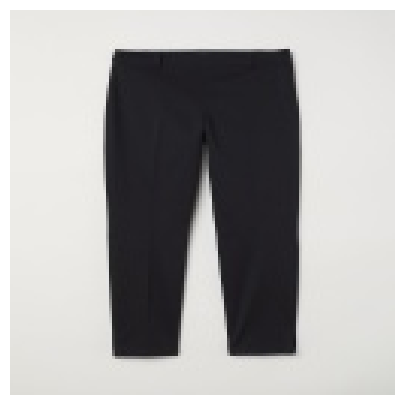

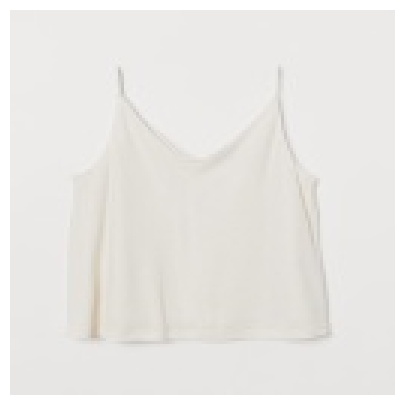

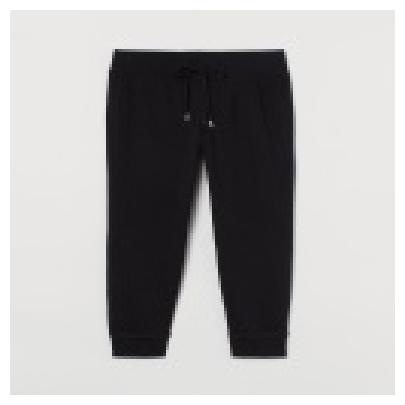

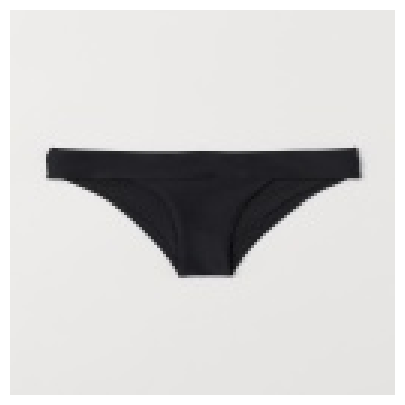

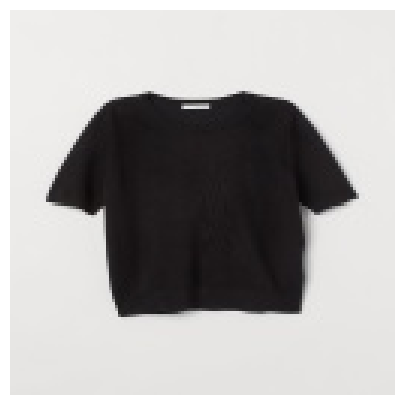

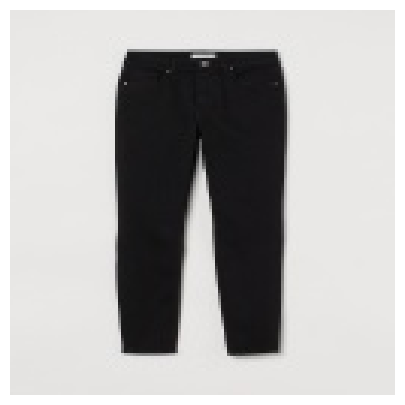

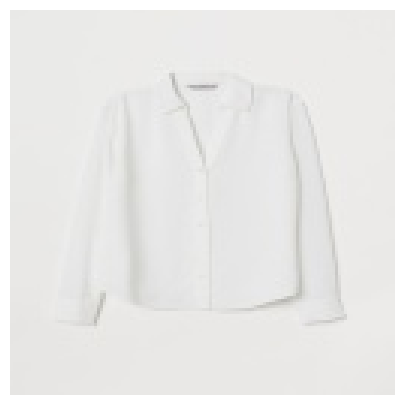

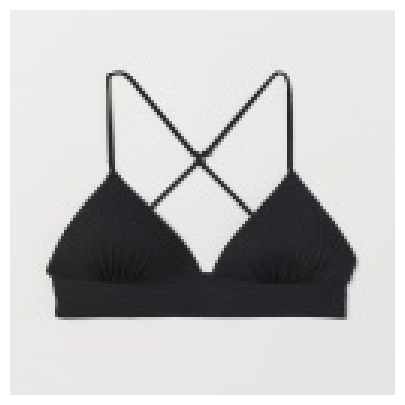

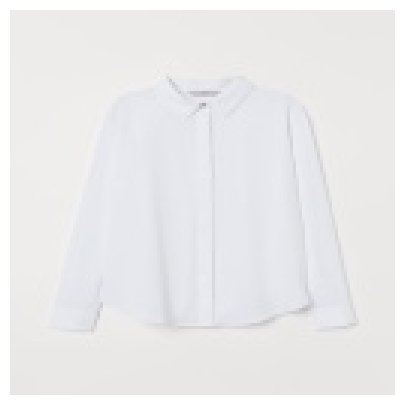

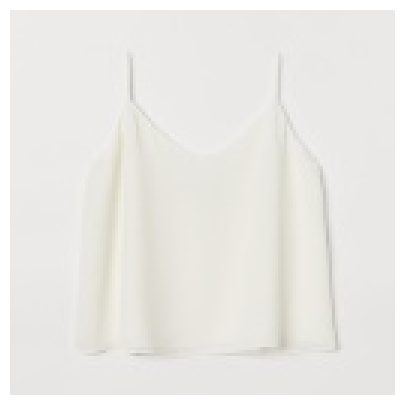

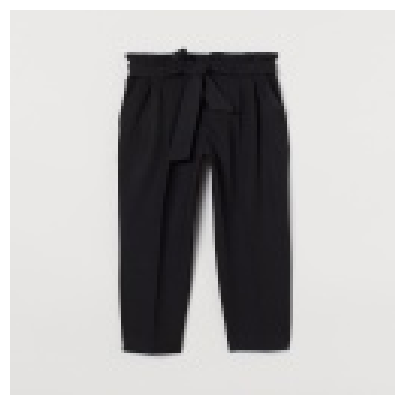

In [372]:
import cv2
for id in recommend_list.also_bought:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  plt.figure(figsize=(20,5))
  if (type(cv2.imread(name1)) == np.ndarray):
    img1 = cv2.imread(name1)[:,:,::-1]
    plt.axis('off')
    plt.imshow(img1)

# True Accuracy

In [374]:
from matplotlib.projections.geo import Transform
import warnings
warnings.filterwarnings("ignore")

hit = 0
for customer_id in customers.customer_id: # for each customer 
  trans = transactions[transactions['customer_id'] == customer_id] # all transactions made by this customer
  recommend_list = pd.DataFrame() # will store all recommended articles (for all but last articles bought by the customer)
  for art_id in trans.article_id[:-1]: # for each article in the customer's transactions (except for last one)
    recommend_articles = res_edges[res_edges['article_id'] == art_id]
    recommend_list = pd.concat([recommend_list, recommend_articles], ignore_index=True)
  if len(recommend_list) > 0:
    recommend_list = recommend_list.groupby('also_bought').max().reset_index()
    recommend_list = recommend_list.drop_duplicates(subset=['also_bought'])
    recommend_list = recommend_list.sort_values(by='res',ascending=False)
    recommend_list = recommend_list[:50]

  test_id = trans.article_id.iloc[-1] # the last article bought by this customer
  if len(recommend_list) > 0:
    if test_id in np.array(recommend_list.article_id): # check if the article is recommended
      hit += 1
acc = hit/len(customers)
print('Accuracy: ', acc)

Accuracy:  0.12329317269076305


In [375]:
from matplotlib.projections.geo import Transform
import warnings
warnings.filterwarnings("ignore")

hit = 0
for customer_id in customers.customer_id: # for each customer 
  trans = transactions[transactions['customer_id'] == customer_id] # all transactions made by this customer
  recommend_list = pd.DataFrame() # will store all recommended articles (for all but last articles bought by the customer)
  for art_id in trans.article_id[:-1]: # for each article in the customer's transactions (except for last one)
    recommend_articles = res_edges[res_edges['article_id'] == art_id]
    recommend_list = pd.concat([recommend_list, recommend_articles], ignore_index=True)
  if len(recommend_list) > 0:
    recommend_list = recommend_list.groupby('also_bought').max().reset_index()
    recommend_list = recommend_list.drop_duplicates(subset=['also_bought'])
    recommend_list = recommend_list.sort_values(by='res',ascending=False)
    recommend_list = recommend_list[:100]

  test_id = trans.article_id.iloc[-1] # the last article bought by this customer
  if len(recommend_list) > 0:
    if test_id in np.array(recommend_list.article_id): # check if the article is recommended
      hit += 1
acc = hit/len(customers)
print('Accuracy: ', acc)

Accuracy:  0.13714859437751004


In [376]:
from matplotlib.projections.geo import Transform
import warnings
warnings.filterwarnings("ignore")

hit = 0
for customer_id in customers.customer_id: # for each customer 
  trans = transactions[transactions['customer_id'] == customer_id] # all transactions made by this customer
  recommend_list = pd.DataFrame() # will store all recommended articles (for all but last articles bought by the customer)
  for art_id in trans.article_id[:-1]: # for each article in the customer's transactions (except for last one)
    recommend_articles = res_edges[res_edges['article_id'] == art_id]
    recommend_list = pd.concat([recommend_list, recommend_articles], ignore_index=True)
  if len(recommend_list) > 0:
    recommend_list = recommend_list.groupby('also_bought').max().reset_index()
    recommend_list = recommend_list.drop_duplicates(subset=['also_bought'])
    recommend_list = recommend_list.sort_values(by='res',ascending=False)
    recommend_list = recommend_list[:150]

  test_id = trans.article_id.iloc[-1] # the last article bought by this customer
  if len(recommend_list) > 0:
    if test_id in np.array(recommend_list.article_id): # check if the article is recommended
      hit += 1
acc = hit/len(customers)
print('Accuracy: ', acc)

Accuracy:  0.14738955823293173


# Training loop (Old Version - split train-test)

In [ ]:
# ----------- set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


In [ ]:
# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In [ ]:
true_pos = np.sum(pos_score.detach().numpy() >= 0, axis=0)
true_neg = np.sum(neg_score.detach().numpy() <= 0, axis=0)
accuracy = (true_pos + true_neg) / (len(pos_score)+len(neg_score))
accuracy

In [ ]:
pos_score

In [ ]:
neg_score

In [ ]:
train_pos_g, h

In [ ]:
h.shape

In [ ]:
pred(test_pos_g, h)

In [ ]:
pred(test_neg_g, h)

In [ ]:
test_neg_g

In [ ]:
test_pos_g

In [ ]:
test_pos_g

In [ ]:
train_pos_g 